In [119]:

import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from src.models.model_v2 import EnhancedMusicGenerator
import matplotlib as plt

In [120]:

# Parameters
config = {
    'seq_length': 50,
    'subset_size': 500000,
    'batch_size': 64,
    'epochs': 50,
    'patience': 5
}

In [121]:
with open('../data/processed_v2/Bach_all_songs_v2.pkl', 'rb') as f:
    sequences = pickle.load(f)

def process_sequences_with_intervals(sequences, seq_length):
    X_notes, X_durations, X_velocities, X_intervals, y_notes = [], [], [], [], []

    for sequence in sequences:
        # Filter and extract valid events
        valid_events = [event for event in sequence
                        if event['type'] in ['note_on', 'note_off'] and pd.notna(event['note'])]

        # Extract features: note, duration, and velocity
        notes = [event['note'] for event in valid_events]
        durations = [event.get('duration', 0.25) for event in valid_events]
        velocities = [event.get('velocity', 64) for event in valid_events]

        # Calculate intervals (pitch differences)
        intervals = [0] + [notes[i + 1] - notes[i] for i in range(len(notes) - 1)]

        # Step 1: Before shifting, verify intervals
        print(f"Intervals before shifting: Max={max(intervals)}, Min={min(intervals)}")

        # Step 2: Shift intervals by +65 and clip to valid range
        intervals_shifted = [min(max(interval + 65, 0), 129) for interval in intervals]  # Clip between 0-129
        print(f"Intervals after shifting: Max={max(intervals_shifted)}, Min={min(intervals_shifted)}")

        # Create input-output pairs
        for i in range(len(notes) - seq_length):
            X_notes.append(notes[i:i + seq_length])
            X_durations.append(durations[i:i + seq_length])
            X_velocities.append(velocities[i:i + seq_length])
            X_intervals.append(intervals_shifted[i:i + seq_length])
            y_notes.append(notes[i + seq_length])

    return (np.array(X_notes), np.array(X_durations), np.array(X_velocities), np.array(X_intervals)), np.array(y_notes)

# Process sequences
(X_notes, X_durations, X_velocities, X_intervals), y = process_sequences_with_intervals(sequences, config['seq_length'])

print(f"Processed data shapes: X_notes={X_notes.shape}, X_durations={X_durations.shape}, "
      f"X_velocities={X_velocities.shape}, X_intervals={X_intervals.shape}, y={y.shape}")


Intervals before shifting: Max=43, Min=-43
Intervals after shifting: Max=108, Min=22
Intervals before shifting: Max=24, Min=-24
Intervals after shifting: Max=89, Min=41
Intervals before shifting: Max=47, Min=-46
Intervals after shifting: Max=112, Min=19
Intervals before shifting: Max=43, Min=-45
Intervals after shifting: Max=108, Min=20
Intervals before shifting: Max=35, Min=-35
Intervals after shifting: Max=100, Min=30
Intervals before shifting: Max=28, Min=-28
Intervals after shifting: Max=93, Min=37
Intervals before shifting: Max=48, Min=-48
Intervals after shifting: Max=113, Min=17
Intervals before shifting: Max=24, Min=-28
Intervals after shifting: Max=89, Min=37
Intervals before shifting: Max=31, Min=-38
Intervals after shifting: Max=96, Min=27
Intervals before shifting: Max=48, Min=-48
Intervals after shifting: Max=113, Min=17
Intervals before shifting: Max=40, Min=-38
Intervals after shifting: Max=105, Min=27
Intervals before shifting: Max=29, Min=-31
Intervals after shifting: 

In [134]:
# Step 3: Calculate the final number of intervals based on the shifted and clipped range
num_intervals = X_intervals.max() + 1 # Ensure this reflects the correct upper bound
print(f"Final number of intervals: {num_intervals}")



import matplotlib.pyplot as plt
import numpy as np
"""


# Create the histogram
plt.hist(X_intervals, bins=30)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram Example')

# Display the histogram
plt.show()
print(np.unique(X_intervals))
"""

Final number of intervals: 126


"\n\n\n# Create the histogram\nplt.hist(X_intervals, bins=30)\n\n# Add labels and title\nplt.xlabel('Value')\nplt.ylabel('Frequency')\nplt.title('Histogram Example')\n\n# Display the histogram\nplt.show()\nprint(np.unique(X_intervals))\n"

In [135]:
# Encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(y)
print(f"Unique classes: {len(encoder.classes_)}")

Unique classes: 80


In [136]:

#num_intervals = 126

# Define model parameters
num_notes = len(encoder.classes_)       # Number of unique notes (output classes)
num_durations = 32                      # Quantized duration categories (adjust as needed)
num_velocities = 128                    # MIDI velocity range (0–127)
embed_dim = 64                          # Embedding dimension
hidden_dim = 256                        # LSTM hidden size
output_dim = len(encoder.classes_)      # Number of output classes (same as num_notes)

# Initialize the model
model = EnhancedMusicGenerator(num_notes=num_notes,
                               num_durations=num_durations,
                               num_velocities=num_velocities,
                               num_intervals=num_intervals,  # Pass calculated num_intervals
                               hidden_dim=hidden_dim,
                               embed_dim=embed_dim,
                               output_dim=output_dim,
                               num_layers=3)

# Print model architecture
print(model)


EnhancedMusicGenerator(
  (note_embedding): Embedding(80, 64)
  (duration_embedding): Embedding(32, 64)
  (velocity_embedding): Embedding(128, 64)
  (interval_embedding): Embedding(126, 64)
  (lstm): LSTM(256, 256, num_layers=3, batch_first=True)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=80, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


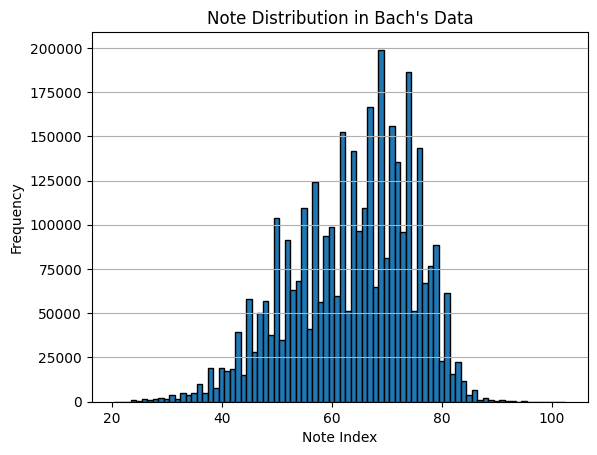

In [137]:

# Path to processed data
PROCESSED_DATA_PATH = '/Users/25lim/Project04_MusicGenerator/src/data/processed_v2/Bach_all_songs_v2.pkl'

# Load Bach's all songs data
with open(PROCESSED_DATA_PATH, 'rb') as f:
    bach_all_songs = pickle.load(f)

# Flatten all notes from Bach's songs
all_notes = [event['note'] for song in bach_all_songs for event in song if 'note' in event and event['note'] is not None]

# Plot the histogram of note distribution
plt.hist(all_notes, bins=range(min(all_notes), max(all_notes) + 2), edgecolor='black', align='left')
plt.title("Note Distribution in Bach's Data")
plt.xlabel("Note Index")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.show()

print()


In [155]:
# Determine the highest and lowest notes
highest_note = max(all_notes)
lowest_note = min(all_notes)

# Print the note range
print(f"Lowest note: {lowest_note}")
print(f"Highest note: {highest_note}")
print(f"Note range: {lowest_note} to {highest_note}")
print(f"Num notes:  {num_notes}")

Lowest note: 21
Highest note: 102
Note range: 21 to 102
Num notes:  80


In [156]:
# Split data into train and validation sets
X_notes_train, X_notes_val, \
X_durations_train, X_durations_val, \
X_velocities_train, X_velocities_val, \
X_intervals_train, X_intervals_val, \
y_train, y_val = train_test_split(
    X_notes, X_durations, X_velocities, X_intervals, y, test_size=0.2, random_state=42
)

# Ensure data is in NumPy array format
X_notes_train = np.array(X_notes_train)
X_notes_val = np.array(X_notes_val)
X_durations_train = np.array(X_durations_train)
X_durations_val = np.array(X_durations_val)
X_velocities_train = np.array(X_velocities_train)
X_velocities_val = np.array(X_velocities_val)
X_intervals_train = np.array(X_intervals_train)
X_intervals_val = np.array(X_intervals_val)
y_train = np.array(y_train)

# Subsample 10% of the training data
subsample_fraction = 0.1
random_indices = np.random.choice(len(X_notes_train), size=int(len(X_notes_train) * subsample_fraction), replace=False)

X_notes_train = X_notes_train[random_indices]
X_durations_train = X_durations_train[random_indices]
X_velocities_train = X_velocities_train[random_indices]
X_intervals_train = X_intervals_train[random_indices]
y_train = y_train[random_indices]


In [157]:
# Adjust note indices to start from 0
X_notes_train = np.clip(X_notes_train - 21, 0, 79)
X_notes_val = np.clip(X_notes_val - 21, 0, 79)

# Quantize durations to match embedding range
duration_bins = np.linspace(0, 1, model.duration_embedding.num_embeddings)
X_durations_train = np.digitize(X_durations_train, bins=duration_bins) - 1
X_durations_val = np.digitize(X_durations_val, bins=duration_bins) - 1

# Shift and clip intervals to match the valid range
X_intervals_train = np.clip(X_intervals_train, 0, num_intervals - 1)
X_intervals_val = np.clip(X_intervals_val, 0, num_intervals - 1)

# Print shapes for verification
print(f"Train shapes: X_notes={X_notes_train.shape}, X_durations={X_durations_train.shape}, "
      f"X_velocities={X_velocities_train.shape}, X_intervals={X_intervals_train.shape}, y={y_train.shape}")
print(f"Validation shapes: X_notes={X_notes_val.shape}, X_durations={X_durations_val.shape}, "
      f"X_velocities={X_velocities_val.shape}, X_intervals={X_intervals_val.shape}, y={y_val.shape}")


Train shapes: X_notes=(281385, 50), X_durations=(281385, 50), X_velocities=(281385, 50), X_intervals=(281385, 50), y=(281385,)
Validation shapes: X_notes=(703463, 50), X_durations=(703463, 50), X_velocities=(703463, 50), X_intervals=(703463, 50), y=(703463,)


In [158]:
def validate_ranges(name, X_notes, X_durations, X_velocities, X_intervals, y):
    print(f"\n--- Verifying {name} Data Ranges ---")
    print(f"Notes: Max={X_notes.max()}, Min={X_notes.min()}, Valid Range: 0-{model.note_embedding.num_embeddings - 1}")
    print(f"Durations: Max={X_durations.max()}, Min={X_durations.min()}, Valid Range: 0-{model.duration_embedding.num_embeddings - 1}")
    print(f"Velocities: Max={X_velocities.max()}, Min={X_velocities.min()}, Valid Range: 0-{model.velocity_embedding.num_embeddings - 1}")
    print(f"Intervals: Max={X_intervals.max()}, Min={X_intervals.min()}, Valid Range: 0-{model.interval_embedding.num_embeddings - 1}")

# Verify ranges for training and validation data
validate_ranges("Training", X_notes_train, X_durations_train, X_velocities_train, X_intervals_train, y_train)
validate_ranges("Validation", X_notes_val, X_durations_val, X_velocities_val, X_intervals_val, y_val)


--- Verifying Training Data Ranges ---
Notes: Max=79, Min=0, Valid Range: 0-79
Durations: Max=31, Min=0, Valid Range: 0-31
Velocities: Max=127, Min=0, Valid Range: 0-127
Intervals: Max=125, Min=0, Valid Range: 0-125

--- Verifying Validation Data Ranges ---
Notes: Max=79, Min=0, Valid Range: 0-79
Durations: Max=31, Min=0, Valid Range: 0-31
Velocities: Max=127, Min=0, Valid Range: 0-127
Intervals: Max=125, Min=0, Valid Range: 0-125


In [159]:
def create_dataloader(X_notes, X_durations, X_velocities, X_intervals, y, batch_size):
    # Convert inputs to tensors
    X_notes_tensor = torch.tensor(X_notes, dtype=torch.long)
    X_durations_tensor = torch.tensor(X_durations, dtype=torch.long)
    X_velocities_tensor = torch.tensor(X_velocities, dtype=torch.long)
    X_intervals_tensor = torch.tensor(X_intervals, dtype=torch.long)
    y_tensor = torch.tensor(y, dtype=torch.long)

    dataset = TensorDataset(X_notes_tensor, X_durations_tensor, X_velocities_tensor, X_intervals_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Create DataLoaders
train_loader = create_dataloader(X_notes_train, X_durations_train, X_velocities_train, X_intervals_train, y_train, config['batch_size'])
val_loader = create_dataloader(X_notes_val, X_durations_val, X_velocities_val, X_intervals_val, y_val, config['batch_size'])

# Check a single batch
for notes_batch, durations_batch, velocities_batch, intervals_batch, targets in train_loader:
    print("\n--- Batch Check ---")
    print(f"Notes: {notes_batch.shape}, Durations: {durations_batch.shape}, Velocities: {velocities_batch.shape}, Intervals: {intervals_batch.shape}, Targets: {targets.shape}")
    break


--- Batch Check ---
Notes: torch.Size([64, 50]), Durations: torch.Size([64, 50]), Velocities: torch.Size([64, 50]), Intervals: torch.Size([64, 50]), Targets: torch.Size([64])


In [160]:
print("\n--- Final Checks ---")
print(f"Max note index: {X_notes_train.max()}")
print(f"Max duration index: {X_durations_train.max()}")
print(f"Max velocity index: {X_velocities_train.max()}")
print(f"Max interval index: {X_intervals_train.max()}")
print(f"Max label index in y_train: {y_train.max()}")
print(f"Model output dimension: {model.fc2.out_features}")



--- Final Checks ---
Max note index: 79
Max duration index: 31
Max velocity index: 127
Max interval index: 125
Max label index in y_train: 78
Model output dimension: 80


In [162]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Epoch [1/50], Batch [256/4397], Loss: 3.2669
Epoch [1/50], Batch [512/4397], Loss: 3.2476
Epoch [1/50], Batch [768/4397], Loss: 3.3492
Epoch [1/50], Batch [1024/4397], Loss: 3.2645
Epoch [1/50], Batch [1280/4397], Loss: 3.1290
Epoch [1/50], Batch [1536/4397], Loss: 3.1101
Epoch [1/50], Batch [1792/4397], Loss: 3.1854
Epoch [1/50], Batch [2048/4397], Loss: 3.3265
Epoch [1/50], Batch [2304/4397], Loss: 3.1386
Epoch [1/50], Batch [2560/4397], Loss: 3.3848
Epoch [1/50], Batch [2816/4397], Loss: 3.2672
Epoch [1/50], Batch [3072/4397], Loss: 3.1851
Epoch [1/50], Batch [3328/4397], Loss: 3.0233
Epoch [1/50], Batch [3584/4397], Loss: 3.0869
Epoch [1/50], Batch [3840/4397], Loss: 3.0957
Epoch [1/50], Batch [4096/4397], Loss: 3.0900
Epoch [1/50], Batch [4352/4397], Loss: 3.0022
Epoch 1 completed. Train Loss: 3.1715
Epoch 1/50, Train Loss: 3.1715
Validation Loss: 3.0150
New best model saved to /Users/25lim/Project04_MusicGenerator/src/results/music_model_v3.pth
Epoch [2/50], Batch [256/4397], Los

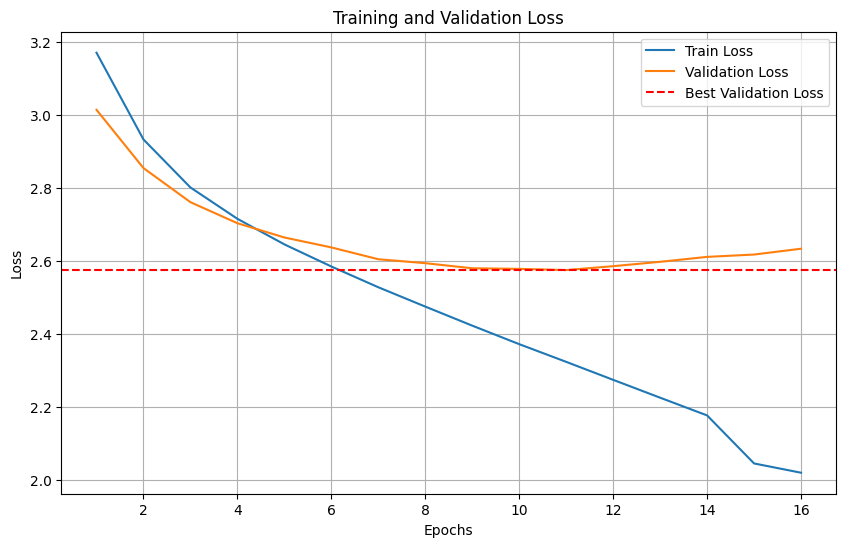

In [164]:


# Initialize lists to store losses
train_losses = []
val_losses = []

# Early stopping variables
best_val_loss = float('inf')
patience_counter = 0
patience = config['patience']  # Number of epochs to wait for improvement
best_model_path = "/Users/25lim/Project04_MusicGenerator/src/results/music_model_v3.pth"

# Initialize scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

# Training loop
for epoch in range(config['epochs']):
    model.train()
    train_loss = 0

    # Training step
    for batch_idx, (notes_batch, durations_batch, velocities_batch, intervals_batch, targets) in enumerate(train_loader):
        optimizer.zero_grad()

        # Forward pass
        outputs = model(notes_batch, durations_batch, velocities_batch, intervals_batch)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        train_loss += loss.item()

        # Print progress every 256 batches
        if (batch_idx + 1) % 256 == 0:
            print(f"Epoch [{epoch + 1}/{config['epochs']}], Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # Record average training loss
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch + 1} completed. Train Loss: {avg_train_loss:.4f}")

    # Validation step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for notes_batch, durations_batch, velocities_batch, intervals_batch, targets in val_loader:
            outputs = model(notes_batch, durations_batch, velocities_batch, intervals_batch)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    # Normalize validation loss
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Update scheduler
    scheduler.step(avg_val_loss)

    # Print epoch results
    print(f"Epoch {epoch + 1}/{config['epochs']}, Train Loss: {avg_train_loss:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}")

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset patience counter
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved to {best_model_path}")
    else:
        patience_counter += 1
        print(f"Early stopping patience: {patience_counter}/{patience}")

    # Stop training if patience is exceeded
    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

# Final results
print("Training complete!")
print(f"Best Validation Loss: {best_val_loss:.4f}")


# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.axhline(y=best_val_loss, color="red", linestyle="--", label="Best Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.savefig("/Users/25lim/Project04_MusicGenerator/src/results/loss_plot_v3.png", dpi=300, bbox_inches="tight")
plt.show()

# Save the final model (if not already saved as the best)
if patience_counter < patience:
    torch.save(model.state_dict(), best_model_path)
    print(f"Final model saved to {best_model_path}")


In [17]:
# Load the best model
state_dict = torch.load(best_model_path, weights_only=True)
model.load_state_dict(state_dict)
model.eval()

# Evaluate on validation data
val_loss = 0
with torch.no_grad():
    for notes_batch, durations_batch, velocities_batch, targets in val_loader:
        outputs = model(notes_batch, durations_batch, velocities_batch)
        loss = criterion(outputs, targets)
        val_loss += loss.item()

print(f"Final Validation Loss of Best Model: {val_loss / len(val_loader):.4f}")


KeyboardInterrupt: 

In [18]:
# Take one sequence from validation data
sample_notes = X_notes_val[:1]
sample_durations = X_durations_val[:1]
sample_velocities = X_velocities_val[:1]

with torch.no_grad():
    notes_tensor = torch.tensor(sample_notes, dtype=torch.long)
    durations_tensor = torch.tensor(sample_durations, dtype=torch.long)
    velocities_tensor = torch.tensor(sample_velocities, dtype=torch.long)

    output = model(notes_tensor, durations_tensor, velocities_tensor)
    predicted_note = torch.argmax(output, dim=1).item()

print(f"Predicted note: {predicted_note}")


Predicted note: 30


In [20]:
state_dict = torch.load(best_model_path, weights_only=True)
for param_tensor in state_dict:
    print(f"{param_tensor}: {state_dict[param_tensor].size()}")

with torch.no_grad():
    probabilities = torch.softmax(output, dim=1)
    print(f"Top probabilities: {probabilities.topk(5)}")


note_embedding.weight: torch.Size([80, 64])
duration_embedding.weight: torch.Size([32, 64])
velocity_embedding.weight: torch.Size([128, 64])
lstm.weight_ih_l0: torch.Size([1024, 192])
lstm.weight_hh_l0: torch.Size([1024, 256])
lstm.bias_ih_l0: torch.Size([1024])
lstm.bias_hh_l0: torch.Size([1024])
lstm.weight_ih_l1: torch.Size([1024, 256])
lstm.weight_hh_l1: torch.Size([1024, 256])
lstm.bias_ih_l1: torch.Size([1024])
lstm.bias_hh_l1: torch.Size([1024])
lstm.weight_ih_l2: torch.Size([1024, 256])
lstm.weight_hh_l2: torch.Size([1024, 256])
lstm.bias_ih_l2: torch.Size([1024])
lstm.bias_hh_l2: torch.Size([1024])
fc1.weight: torch.Size([64, 256])
fc1.bias: torch.Size([64])
fc2.weight: torch.Size([80, 64])
fc2.bias: torch.Size([80])
Top probabilities: torch.return_types.topk(
values=tensor([[0.2102, 0.2014, 0.1059, 0.0612, 0.0556]]),
indices=tensor([[30, 54, 31, 50, 33]]))
